In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/Rogers_022824.csv')
df["purchase_datetime"] = pd.to_datetime(df["purchase_datetime"])
df.drop(columns=["sku","price","currency","total_price"], inplace=True)
df.rename(columns={"purchase_datetime":"exit_time", "trip_duration_mins":"flow_time"}, inplace=True)
df["entry_time"] = df["exit_time"] - pd.to_timedelta(df["flow_time"], unit="m")
neworder = ["entry_time","exit_time","flow_time","session_id","group_size","product_title"]
df = df[neworder]


In [104]:
grp = df.groupby(["entry_time","exit_time","flow_time","session_id","group_size"])["product_title"].agg(prod_count="count").reset_index()
grp.sort_values(by="entry_time", ascending=True, inplace=True)
print(grp.info())
grp.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2182 entries, 0 to 2181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   entry_time  2182 non-null   datetime64[ns]
 1   exit_time   2182 non-null   datetime64[ns]
 2   flow_time   2182 non-null   float64       
 3   session_id  2182 non-null   object        
 4   group_size  2182 non-null   int64         
 5   prod_count  2182 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 119.3+ KB
None


,entry_time,exit_time,flow_time,session_id,group_size,prod_count
0,2024-02-28 07:01:56.004,2024-02-28 07:03:00,1.0666,ee05da65-08a6-40e8-bad0-cc97cbb979b0,1,3
1,2024-02-28 07:08:03.000,2024-02-28 07:09:00,0.9500,51be7741-b716-4478-be50-ef2b5f52d69d,1,1
2,2024-02-28 07:08:09.000,2024-02-28 07:09:00,0.8500,e63a092b-2814-4358-a2f9-e9354c72d829,1,1
3,2024-02-28 07:16:14.004,2024-02-28 07:17:00,0.7666,92e469b4-d9e7-4028-bb22-c7fb6fde6b8c,1,1
4,2024-02-28 07:23:14.004,2024-02-28 07:26:00,2.7666,edeec561-2161-417a-8099-fd16999a961d,1,1


Average hourly throughput rate is 148.25 customers


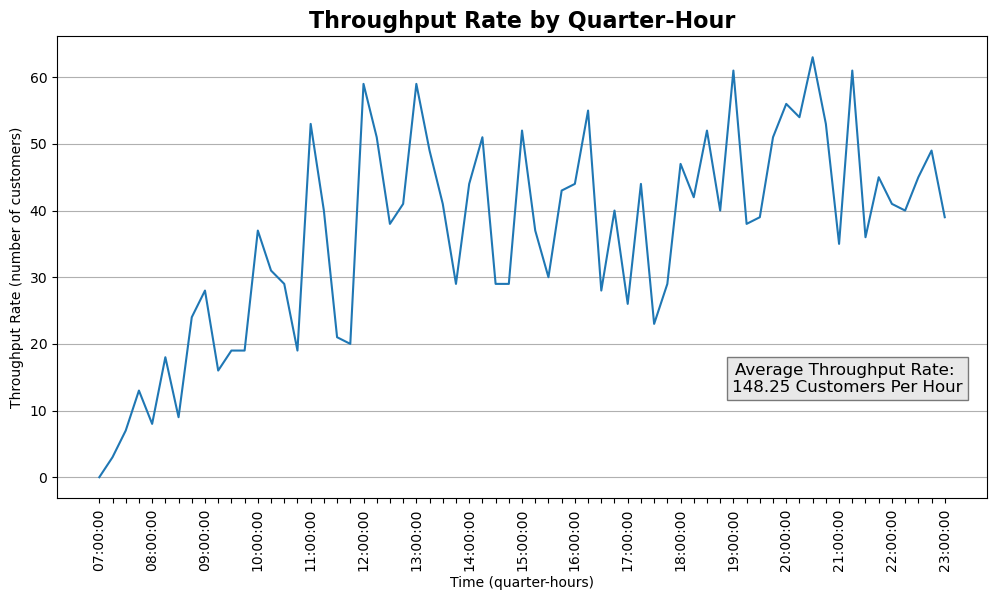

In [105]:
# Question 1:

quarter_hours = pd.date_range(start='2024-02-28 07:00:00', end='2024-02-28 23:00:00', freq='15min')
qtr = pd.DataFrame(quarter_hours, columns=["quarter_hour"])

qtr["rate"] = [0] + [grp.loc[(grp["entry_time"] <= qtr["quarter_hour"][i]) 
                        & (grp["entry_time"] > qtr["quarter_hour"][i - 1]), "group_size"].sum() 
                           for i in range(1,len(qtr["quarter_hour"]))]

avg_rate = qtr["rate"].sum() / ((len(qtr["rate"])-1)/4)
print(f"Average hourly throughput rate is {avg_rate} customers")
      
plt.figure(figsize=(12,6))
plt.plot(qtr["quarter_hour"], qtr["rate"])

plt.xlabel("Time (quarter-hours)")
labels = [str(x.time()) if i % 4 == 0 else "" for i, x in enumerate(qtr["quarter_hour"])]
plt.xticks(rotation=90, labels=labels, ticks=qtr["quarter_hour"])

plt.ylabel("Throughput Rate (number of customers)")
plt.grid(True, axis="y")

plt.title("Throughput Rate by Quarter-Hour", fontsize=16, weight="bold")
plt.annotate(f"Average Throughput Rate: \n{avg_rate} Customers Per Hour", xy=(.85,.23), xycoords="axes fraction", 
             ha="center", fontsize=12, bbox=dict(facecolor="lightgray", alpha=0.5))
plt.show()


In [106]:
# Question 2:

avg_flow = np.dot(grp["flow_time"],grp["group_size"])/grp["group_size"].sum()
#take the weighted average of the flow_time values based on the number from the group_size column 
avg_flow2 = np.average(grp["flow_time"], weights=grp["group_size"])
avg_flow_hr = avg_flow/60

print(f"Average flow time is {round(avg_flow,3)} minutes or {round(avg_flow_hr,3)} hours")


Average flow time is 2.105 minutes or 0.035 hours


In [107]:
# Question 3:
start_time = grp["entry_time"].iloc[0]
end_time = grp["entry_time"].iloc[-1]

np.random.seed(30)
random_times = start_time + pd.to_timedelta(np.random.uniform(0, (end_time-start_time).total_seconds(), 1000), unit="s")
rand = np.array(random_times)

avg_inv = np.mean([grp.loc[(grp["entry_time"] <= rand[i]) & (rand[i] < grp["exit_time"])
                 , "group_size"].sum() 
                 for i in range(1000)])

print(f"The average customer inventory is {avg_inv} customers at any given point in time")


The average customer inventory is 5.204 customers at any given point in time


In [108]:
# Question 4: 
# Little's Law: inventory (cust) = flow time (hrs) * throughput rate (cust/hr)

little_flow = avg_inv / avg_rate
little_rate = avg_inv / avg_flow_hr
little_inv = avg_flow_hr * avg_rate

print(f"Average flow time is {round(avg_flow_hr,3)} hours compared to a calculated value of {round(little_flow,3)} hours")
print(f"Average hourly throughput rate is {avg_rate} customers compared to a calculated value of {round(little_rate,3)} customers")
print(f"The average customer inventory is {avg_inv} compared to a calculated value of {round(little_inv,3)} customers")

# inventory (cust) = flow time (hours) * throughput rate (cust/hr)

Average flow time is 0.035 hours compared to a calculated value of 0.035 hours
Average hourly throughput rate is 148.25 customers compared to a calculated value of 148.328 customers
The average customer inventory is 5.204 compared to a calculated value of 5.201 customers
